<a href="https://colab.research.google.com/github/hijuliosantos/pos-deeplearning/blob/main/Trabalho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Classificação de textos para análise de sentimentos

Base de dados 

Istruções:
- O objetivo deste trabalho é criar um modelo binário de aprendizado de máquina para classificação de textos. 
Para isso, será utilizado a base de dados [IMDb](http://ai.stanford.edu/~amaas/data/sentiment/), que consiste de dados textuais de críticas positivas e negativas de filmes
- Uma vez treinado, o modelo deve ter uma função `predict` que recebe uma string como parâmetro e retorna o valor 1 ou 0, aonde 1 significa uma crítica positiva e 0 uma crítica negativa
- O pré-processamento pode ser desenvolvidado conforme desejar (ex.: remoção de stopwords, word embedding, one-hot encoding, char encoding)
- É preferível que seja empregado um modelo de recorrência (ex.: rnn, lstm, gru) para a etapa de classificação
- Documente o código (explique sucintamente o que cada função faz, insira comentários em trechos de código relevantes)
- **Atenção**: Uma vez treinado o modelo final, salve-o no diretório do seu projeto e crie uma célula ao final do notebook contendo uma função de leitura deste arquivo, juntamente com a execução da função `predict`

Sugestões:
- Explorar a base de dados nas células iniciais do notebook para ter um melhor entendimento do problema, distribuição dos dados, etc
- Após desenvolver a estrutura de classificação, é indicado fazer uma busca de hiperparâmetros e comparar os resultados obtidos em diferentes situações

Prazo de entrega:
- 26-06-2021 às 23:59hs GMT-3

Formato preferível de entrega:
- Postar no portal Ava da disciplina o link do projeto no github (ou anexar o projeto diretamente no portal Ava)

luann.porfirio@gmail.com

# Imports e rápida análise nos dados

Inicialmente realizo a importação das bibliotecas necessárias para o desenvolvimento deste trabalho. Spacy para pnl e pytorch para redes recorrentes.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
import random
import re
import spacy

from torch.utils.data import random_split
from torchtext.legacy.data import LabelField, Field, Example, Dataset, Iterator
from torchtext.vocab import GloVe
from torchtext import datasets
from bs4 import BeautifulSoup

# Para testes com o nltk. Foi escolhida a biblioteca Spacy para o processamento de linguagem natural
'''import nltk
nltk.download(['stopwords', 'wordnet', 'vader_lexicon', 'punkt'])

from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment import SentimentIntensityAnalyzer'''

"import nltk\nnltk.download(['stopwords', 'wordnet', 'vader_lexicon', 'punkt'])\n\nfrom nltk import word_tokenize, FreqDist\nfrom nltk.corpus import stopwords\nfrom nltk.stem import WordNetLemmatizer\nfrom nltk.stem.snowball import SnowballStemmer\nfrom nltk.sentiment import SentimentIntensityAnalyzer"

Leitura dos datasets (treino/teste). Transformo em data frame pandas para facilitar realizar análise exploratória.

In [ ]:
train_iter, test_iter = datasets.IMDB()
df_train = pd.DataFrame(train_iter, columns=["sentiment", "review"])
df_test = pd.DataFrame(test_iter, columns=["sentiment", "review"])

In [ ]:
df_train['sentiment'].value_counts()

neg    12500
pos    12500
Name: sentiment, dtype: int64

In [ ]:
df_train.head(5)

,sentiment,review
0,neg,I rented I AM CURIOUS-YELLOW from my video sto...
1,neg,"""I Am Curious: Yellow"" is a risible and preten..."
2,neg,If only to avoid making this type of film in t...
3,neg,This film was probably inspired by Godard's Ma...
4,neg,"Oh, brother...after hearing about this ridicul..."


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  25000 non-null  object
 1   review     25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [ ]:
df_test['sentiment'].value_counts()

neg    12500
pos    12500
Name: sentiment, dtype: int64

In [ ]:
df_test.head(5)

,sentiment,review
0,neg,I love sci-fi and am willing to put up with a ...
1,neg,"Worth the entertainment value of a rental, esp..."
2,neg,its a totally average film with a few semi-alr...
3,neg,STAR RATING: ***** Saturday Night **** Friday ...
4,neg,"First off let me say, If you haven't enjoyed a..."


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  25000 non-null  object
 1   review     25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [ ]:
df_train['review'].loc[10]
#<br /><br />

'It was great to see some of my favorite stars of 30 years ago including John Ritter, Ben Gazarra and Audrey Hepburn. They looked quite wonderful. But that was it. They were not given any characters or good lines to work with. I neither understood or cared what the characters were doing.<br /><br />Some of the smaller female roles were fine, Patty Henson and Colleen Camp were quite competent and confident in their small sidekick parts. They showed some talent and it is sad they didn\'t go on to star in more and better films. Sadly, I didn\'t think Dorothy Stratten got a chance to act in this her only important film role.<br /><br />The film appears to have some fans, and I was very open-minded when I started watching it. I am a big Peter Bogdanovich fan and I enjoyed his last movie, "Cat\'s Meow" and all his early ones from "Targets" to "Nickleodeon". So, it really surprised me that I was barely able to keep awake watching this one.<br /><br />It is ironic that this movie is about a de

Os dados estão ok, estão divididos proporcionalmente e não há dados nulos. Será necessário tratar o texto e label para o algoritmo de rede recorrente

In [ ]:
#Configurações para reprodutibilidade

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
# for cuda
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

Habilitar GPU cuda se disponível.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Após realizar uma pequena análise nos dados (não precisam de modificações), irei criar o método para aplicar pln no texto. Criarei duas listas com os textos já processados.

In [ ]:
nlp = spacy.load('en')
def clean_review_spacy(review: str) -> str:
  review = BeautifulSoup(review, "html.parser").get_text()
  review = review.lower()
  review = re.sub('[^a-z0-9]', ' ', review)
  review = [tok.text for tok in nlp.tokenizer(review)]
  review = [word for word in review if nlp.vocab[word].is_stop == False]
  review = [word.lemma_ for word in spacy.tokens.Doc(nlp.vocab, words=review)]
  while ' ' in review: review.remove(' ') #bug spacy
  review = ' '.join(review)
  return review

# Mesmo método em NLTK, porém, optei pelo spacy
'''stop_words = set(stopwords.words('english'))
#stemmer = SnowballStemmer("english") 
lem = WordNetLemmatizer()
def clean_review(review: str) -> str:
  review = BeautifulSoup(review, "html.parser").get_text()
  review = review.lower()
  review = re.sub('[^a-z0-9]', ' ', review)
  review = nltk.word_tokenize(review)
  review = [word for word in review if not word in stop_words]
  review = [lem.lemmatize(word) for word in review]
  #review = [stemmer.stem(word) for word in review]
  review = ' '.join(review)
  return review'''

'stop_words = set(stopwords.words(\'english\'))\n#stemmer = SnowballStemmer("english") \nlem = WordNetLemmatizer()\ndef clean_review(review: str) -> str:\n  review = BeautifulSoup(review, "html.parser").get_text()\n  review = review.lower()\n  review = re.sub(\'[^a-z0-9]\', \' \', review)\n  review = nltk.word_tokenize(review)\n  review = [word for word in review if not word in stop_words]\n  review = [lem.lemmatize(word) for word in review]\n  #review = [stemmer.stem(word) for word in review]\n  review = \' \'.join(review)\n  return review'

In [ ]:
clean_train = []
clean_test = []
train_iter, test_iter = datasets.IMDB()
for label, text in train_iter:
  clean_train.append((clean_review_spacy(text), label))

for label, text in test_iter:
  clean_test.append((clean_review_spacy(text), label))

print(clean_train[0])
print(clean_test[0])

('rent curious yellow video store controversy surround release 1967 hear seize u s custom try enter country fan film consider controversial plot center young swedish drama student name lena want learn life particular want focus attention make sort documentary average swede think certain political issue vietnam war race issue unite state ask politician ordinary denizen stockholm opinion politic sex drama teacher classmate marry man kill curious yellow 40 year ago consider pornographic sex nudity scene far s shoot like cheaply porno countryman mind find shock reality sex nudity major staple swedish cinema ingmar bergman arguably answer good old boy john ford sex scene film commend filmmakers fact sex show film show artistic purpose shock people money show pornographic theater america curious yellow good film want study meat potato pun intend swedish cinema film doesn t plot', 'neg')
('love sci fi will lot sci fi movie tv usually underfund appreciate misunderstand try like good tv sci fi 

# Demonstração da transformação nos dados

Os seguintes códigos são somente para demonstrar como os dados são transformados para poderem ser processados por uma RNN/LSTM/GRU. Utilizarei somente dois registros para facilitar a exemplificação.

Iinicialmente é realizado o PLN para limpar o texto.

In [ ]:
print("Texto original:", df_test.iloc[1].review)
print("Sentimento:", df_test.iloc[1].sentiment)
print('')
print("Texto após PLN:", clean_test[1][0])
print("Sentimento:", clean_test[1][1])

print('-' * 1000)
print("Texto original:", df_test.iloc[24999].review)
print("Sentimento:", df_test.iloc[24999].sentiment)
print('')
print("Texto após PLN:", clean_test[24999][0])
print("Sentimento ", clean_test[24999][1])

Texto original:  Worth the entertainment value of a rental, especially if you like action movies. This one features the usual car chases, fights with the great Van Damme kick style, shooting battles with the 40 shell load shotgun, and even terrorist style bombs. All of this is entertaining and competently handled but there is nothing that really blows you away if you've seen your share before.<br /><br />The plot is made interesting by the inclusion of a rabbit, which is clever but hardly profound. Many of the characters are heavily stereotyped -- the angry veterans, the terrified illegal aliens, the crooked cops, the indifferent feds, the bitchy tough lady station head, the crooked politician, the fat federale who looks like he was typecast as the Mexican in a Hollywood movie from the 1940s. All passably acted but again nothing special.<br /><br />I thought the main villains were pretty well done and fairly well acted. By the end of the movie you certainly knew who the good guys were 

Irei utilizar estruturas do pytorch com spacy para tokenizar meu texto (REVIEW) e a categoria (SENTIMENT). A partir disto, será gerado um vocabulário para cada palavra do texto e das categorias. Ao final, gero uma estrutura Iterator do pytorch para conseguir treinar/avaliar utilizando batch.

In [ ]:
CLEAN_TEST = [clean_test[1],clean_test[24999]]
TEXT_TEST = Field(tokenize="spacy", include_lengths=True)
LABEL_TEST = LabelField(dtype=torch.float)
FIELDS_TEST = [('text', TEXT_TEST), ('category', LABEL_TEST)]

DS_TEST = Dataset(list(map(lambda x: Example.fromlist(list(x), fields=FIELDS_TEST), CLEAN_TEST)), fields=FIELDS_TEST)
TEXT_TEST.build_vocab(DS_TEST,  max_size=10000, min_freq=1)
LABEL_TEST.build_vocab(DS_TEST)

dataiter_TEST = Iterator(DS_TEST, batch_size=2, sort_key=lambda x: len(x), device=device)

Como somente existem dois registros, a frequência é 1 para positivo e 1 para negativo. O label neg ficou 0 e pos ficou 1.

In [ ]:
LABEL_TEST.vocab.freqs

Counter({'neg': 1, 'pos': 1})

In [ ]:
print("neg:", LABEL_TEST.vocab['neg'])
print("pos:",LABEL_TEST.vocab['pos'])

neg: 0
pos: 1


Apresento o token correspondente as duas primeiras palavras dos textos. Também apresento uma palavra que não existe no vocabulário, ficando como 0.

In [ ]:
print("catch token:", TEXT_TEST.vocab.stoi["catch"])
print("movie token:", TEXT_TEST.vocab.stoi["movie"])
print("worth token:", TEXT_TEST.vocab.stoi["worth"])
print("entertainment token:", TEXT_TEST.vocab.stoi["entertainment"])
print("teste token:", TEXT_TEST.vocab.stoi["teste"]) # nao exite no vocab

catch token: 40
movie token: 2
worth token: 23
entertainment token: 64
teste token: 0


Irei percorrer a estrutura do BATCH (somente um registro com 2 batch). 

1. A primeira posição do *text* contém os textos do batch tokenizados. **Notar que na primeira posição é o primeiro caractere do primeiro texto (catch = 40). Na segunda posição é o primeiro caractere do segundo texto (worth 23).** 

2. A segunda posição do *text* apresenta o tamanho real do texto para ser utilizado na predição da rede recorrente. Isto é utilizado devido aos limites na entrada de redes neurais, quando se trabalha com dados textuais de tamanhos variados.

3. O *label* apresenta o neg/pos já tokenizados.

In [ ]:
for text, label in dataiter_TEST:
  print("TEXTO TOKENIZADO")
  print(text[0])
  print('')
  print("TEXTO TAMANHO")
  print(text[1])
  print('')
  print("LABEL")
  print(label)

TEXTO TOKENIZADO
tensor([[ 40,  23],
        [  2,  64],
        [124, 151],
        [ 73, 120],
        [ 42,  65],
        [119,  14],
        [  7,  27],
        [146,   2],
        [ 16,  70],
        [ 57, 150],
        [ 68,  38],
        [ 32,   9],
        [ 96,  11],
        [ 13,  77],
        [ 19, 152],
        [ 12,  55],
        [  4,  91],
        [107,  18],
        [ 99, 129],
        [106,  33],
        [  5,  26],
        [123, 127],
        [144,  97],
        [136, 130],
        [156, 140],
        [ 54,  18],
        [159,  36],
        [116,  63],
        [100,  49],
        [103,  79],
        [ 75,  35],
        [128,  31],
        [137,  81],
        [145, 125],
        [ 86, 126],
        [ 58, 114],
        [113,  90],
        [ 39,  88],
        [105, 118],
        [ 21,  45],
        [ 50,  80],
        [112, 117],
        [121,  43],
        [157,  83],
        [ 84, 135],
        [102,   5],
        [ 12,  29],
        [148, 154],
        [ 46, 138],
   

# Modelos

Classe para representar uma RNN, LSTM ou GRU. Parâmetros:

1. vocab_size: tamanho do vocabulário criado com os dados de treinamento
2. embedding_dim: dimensão da camada de embedding
3. hidden_dim: dimensão da camada oculta
4. output_dim: dimensão de saída
5. n_layer ***está adaptado para 1 ou 2 camadas***
6. bidirectional: se a rede será bidirecional ou não
7. Taxa de dropout
8. id do pad
9. id do unk
10. tp: tipo da rede: RNN, LSTM ou GRU

In [ ]:
class RNN(nn.Module):
    def __init__( self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx, unk_idx, tp='RNN'):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.nlp = spacy.load("en")
        if tp == 'RNN':
          self.rnn = nn.RNN(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout
        )
        elif tp == 'LSTM':
          self.rnn = nn.LSTM(
              embedding_dim,
              hidden_dim,
              num_layers=n_layers,
              bidirectional=bidirectional,
              dropout=dropout
          )
        elif tp == 'GRU':
          self.rnn = nn.GRU(
              embedding_dim,
              hidden_dim,
              num_layers=n_layers,
              bidirectional=bidirectional,
              dropout=dropout
          )
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.text_vocab = None
        self.label_vocab = None
        self.tp = tp
        
        self.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
        self.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)
        

    def clean_review_spacy_token(self, review):
        review = BeautifulSoup(review, "html.parser").get_text()
        review = review.lower()
        review = re.sub('[^a-z0-9]', ' ', review)
        review = [tok.text for tok in self.nlp.tokenizer(review)]
        review = [word for word in review if self.nlp.vocab[word].is_stop == False]
        review = [word.lemma_ for word in spacy.tokens.Doc(self.nlp.vocab, words=review)]
        while ' ' in review: review.remove(' ') #bug spacy
        return review

    def predict(self, review):
        if self.text_vocab is None:
          self.text_vocab = torch.load('text_vocab_obj.pth')
        if self.label_vocab is None:
          self.label_vocab = torch.load('label_vocab_obj.pth')

        self.eval()
        with torch.no_grad():
          tokenized = self.clean_review_spacy_token(review)
          indexed = [self.text_vocab.stoi[t] for t in tokenized]
          length = [len(indexed)]
          tensor = torch.LongTensor(indexed).to(device)
          tensor = tensor.unsqueeze(1)

          length_tensor = torch.LongTensor(length)
          prediction = self(tensor, length_tensor)
          prediction = int(torch.round(prediction.squeeze()))
          if self.label_vocab.stoi['neg'] == 1: # PARA GARANTIR QUE O RETORNO FIQUE DE ACORDO COM O ENUNCIADO (1 POSITIVO 0 NEGATIVO)
            prediction = 1 if prediction == 0 else 0
          return prediction

    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))

        # pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), enforce_sorted=False) # devido a um bug, tem que colocar como cpu
        
        if self.tp == 'LSTM':
          packed_output, (hidden, cell) = self.rnn(packed_embedded)
        else:
          packed_output, hidden = self.rnn(packed_embedded)
        
        # unpack sequence
        #output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        if self.rnn.num_layers == 2:
          hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        else:
          hidden = self.dropout(torch.cat((hidden[-1, :, :], hidden[0, :, :]), dim=1))
        return torch.sigmoid(self.fc(hidden))

Métodos para treinar e avaliar a rede. É necessário passar a estrutura de BATCH (treino, teste ou validação), o modelo e o dicionário de parâmetros como entrada. Estes métodos percorrem a estrutura de data loarder (batch), realizam a predição, calculam a loss e a acurácia. Como retorno: taxa de perda,acurácia

Importante notar que no evaluate é desativado o gradiente e ativado o modo eval para o modelo não aprender com dados de teste e validação.

In [ ]:
def train(dataloader, model, dict_params):
    model.train()
    train_loss, train_acc = 0, 0
    for idx, (text, label) in enumerate(dataloader):
        dict_params['OPTIMIZER'].zero_grad()
        predited_label = model(text[0], text[1])
        loss = dict_params['CRITERION'](predited_label.squeeze(), label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        dict_params['OPTIMIZER'].step()
        train_loss += loss.item()

        classes = torch.round(predited_label.squeeze())
        train_acc += torch.mean((classes == label).float())
    return train_acc/len(dataloader), train_loss/len(dataloader)

def evaluate(dataloader, model, dict_params, valid):
    model.eval()
    eval_loss, eval_acc = 0, 0
    with torch.no_grad():
        for idx, (text, label) in enumerate(dataloader):
            predited_label = model(text[0], text[1])
            if valid:
              eval_loss += dict_params['CRITERION'](predited_label.squeeze(), label)

            classes = torch.round(predited_label.squeeze())
            eval_acc += torch.mean((classes == label).float())
    return eval_acc/len(dataloader), eval_loss/len(dataloader)

Método plot_loss_acc para impressão das métricas (loss, acc).

Método execute_model para executar o modelo passado para ele. Isto inclui, treinar, avaliar e apresentar as métricas.

In [ ]:
def plot_loss_acc(train_losses_general: list, val_losses_general: list, train_accuracy_general: list, val_accuracy_general: list) -> None:
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
  axes[0].plot(train_losses_general, label='Training loss')
  axes[0].plot(val_losses_general, label='Validation loss')
  axes[0].legend(frameon=False)

  axes[1].plot(train_accuracy_general, label='Training acc')
  axes[1].plot(val_accuracy_general, label='Validation acc')
  axes[1].legend(frameon=False)
  plt.show()

def execute_model(model, dict_params, dataiter_train, dataiter_val, dataiter_test):
  print(model)
  # Crio a função de perda e o otimizador com base no que foi passado pelo dict
  #criterion = dict_params['CRITERION']
  if dict_params['OPTIMIZER'] == 'ADAM':
    dict_params['OPTIMIZER'] = optim.Adam(model.parameters(), lr=dict_params['LEARNING_RATE']) #weight_decay=0.03
  elif dict_params['OPTIMIZER'] == 'SGD': 
    dict_params['OPTIMIZER'] = torch.optim.SGD(model.parameters(), lr=dict_params['LEARNING_RATE'])

  train_losses_general, val_losses_general, train_accuracy_general, val_accuracy_general = [], [], [], []
  scheduler = torch.optim.lr_scheduler.StepLR(dict_params['OPTIMIZER'], 1.0, gamma=0.1)
  total_accu = None

  for e in range(dict_params['EPOCHS']):
      epoch_start_time = time.time()
      train_acc, train_loss = train(dataiter_train, model, dict_params)
      val_acc, val_loss = evaluate(dataiter_val, model, dict_params, True)
      if total_accu is not None and total_accu > val_acc:
        scheduler.step()
      else:
        total_accu = val_acc

      # Acumula as métricas para posterior impressão de gráficos
      train_losses_general.append(train_loss)
      val_losses_general.append(val_loss)
      train_accuracy_general.append(train_acc)
      val_accuracy_general.append(val_acc)

      # Impressão da época/loss/acc de treino e validação
      print("Epoch: {}/{}.. ".format(e+1,dict_params['EPOCHS']),
            "Train Loss: {:.4f}.. ".format(train_loss),
            "Val Loss: {:.4f}.. ".format(val_loss),
            "Train Acc: {:.4f}.. ".format(train_acc),
            "Val Acc: {:.4f}.. ".format(val_acc),
            "Time: {:5.2f}s".format(time.time() - epoch_start_time))

  # Impressão da loss/acc por época nos treinos e validações
  plot_loss_acc(train_losses_general, val_losses_general, train_accuracy_general, val_accuracy_general)

  # Executo o teste do modelo
  test_acc, test_loss = evaluate(dataiter_test, model, dict_params, False)
  print('-' * 59)
  print("Test ACC: {:.4f}.. ".format(test_acc))
  
  return (model, dict_params)

# Divisão e ajustes na base de dados

Após criar o modelo de RNN e métodos necessário para execução. Irei dividir minha base de treinamento em 0,05% para validação.

Abaixo será feito o mesmo que já havia sido realizado como exemplo anteriormente. Porém, com mais registros:


Irei gerar meu vocabulário com os dados de treinamento. Tokenizar, disponibilizar tamanho dos textos. O vocab terá uma frequência minima de 10 palavras (ou seja, a palavra tem que aparecer pelo menos 10 vezes no texto geral (contando todos os exemplos de treino)).

Transformo meus dados de teste e validação para a mesma estrutura em que foi realizado o treinamento.

In [ ]:
params1 = dict()
params1['BATCH_SIZE'] = 64

num_train = int(len(clean_train) * 0.95)
split_train, split_valid = \
        random_split(clean_train, [num_train, len(clean_train) - num_train])

TEXT = Field(tokenize="spacy", include_lengths=True)
LABEL = LabelField(dtype=torch.float)
FIELDS = [('text', TEXT), ('category', LABEL)]

examples_train = list(map(lambda x: Example.fromlist(list(x), fields=FIELDS), split_train))
ds_train = Dataset(examples_train, fields=FIELDS)
TEXT.build_vocab(ds_train,  max_size=100000, min_freq=10)
LABEL.build_vocab(ds_train)

examples_valid = list(map(lambda x: Example.fromlist(list(x), fields=FIELDS), split_valid))
ds_val = Dataset(examples_valid, fields=FIELDS)
dataiter_val = Iterator(ds_val, batch_size=params1['BATCH_SIZE'], sort_key=lambda x: len(x), device=device)

examples_test = list(map(lambda x: Example.fromlist(list(x), fields=FIELDS), clean_test))
ds_test = Dataset(examples_test, fields=FIELDS)
dataiter_test = Iterator(ds_test, batch_size=params1['BATCH_SIZE'], sort_key=lambda x: len(x), device=device)

dataiter_train = Iterator(ds_train, batch_size=params1['BATCH_SIZE'], sort_key=lambda x: len(x), device=device)

In [ ]:
print("Tamanho do vocabulário:", len(TEXT.vocab))
print("Frequência dos sentimentos nos dados de treino:", LABEL.vocab.freqs)
print("Após fazer transformar em label:", LABEL.vocab.stoi) # No método predict, terei de inverter o 0 para negativo e 1 para positivo para atender o enunciado

Tamanho do vocabulário: 15245
Frequência dos sentimentos nos dados de treino: Counter({'pos': 11903, 'neg': 11847})
Após fazer transformar em label: defaultdict(None, {'pos': 0, 'neg': 1})


# Experimentos

Abaixo irei realizar os experimentos. O primeiro será na estrutura mais simples, uma RNN. 

1. Utilizarei a função de otimização ADAM para todos os experimentos.
2. Utilizarei a função de perda BCELoss (para dados binários) para todos os experimentos.
3. A rede possui a função de ativação sigmoid, eficiente para funções binárias (0 e 1).
4. Utilizarei o dropout 0.3 para todos os experimentos.
5. Utilizarei LR de 0.001 para todos os experimentos.
6. Utilizarei 256 dimensões na camada oculta para todos os experimentos.
7. Utilizarei 100 dimensões na camada de embedding para todos os experimentos.
8. A saída é 1 e a entrada é o tamanho do vocabulário.

* Os demais parâmetros irei variar. Lembrando que redes recorrentes demoram para rodar. É aconselhável utilizar GPU.

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


RNN(
  (embedding): Embedding(15245, 100, padding_idx=1)
  (rnn): RNN(100, 256, dropout=0.3)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Epoch: 1/25..  Train Loss: 0.6585..  Val Loss: 0.6039..  Train Acc: 0.6061..  Val Acc: 0.6875..  Time: 40.86s
Epoch: 2/25..  Train Loss: 0.6104..  Val Loss: 0.5519..  Train Acc: 0.6735..  Val Acc: 0.7460..  Time: 40.91s
Epoch: 3/25..  Train Loss: 0.5681..  Val Loss: 0.5469..  Train Acc: 0.7103..  Val Acc: 0.7384..  Time: 41.13s
Epoch: 4/25..  Train Loss: 0.5117..  Val Loss: 0.5027..  Train Acc: 0.7613..  Val Acc: 0.7655..  Time: 41.55s
Epoch: 5/25..  Train Loss: 0.4940..  Val Loss: 0.4894..  Train Acc: 0.7745..  Val Acc: 0.7723..  Time: 40.97s
Epoch: 6/25..  Train Loss: 0.4769..  Val Loss: 0.4774..  Train Acc: 0.7834..  Val Acc: 0.7820..  Time: 40.84s
Epoch: 7/25..  Train Loss: 0.4578..  Val Loss: 0.4625..  Train Acc: 0.7940..  Val Acc: 0.7881..  Time: 40.74s
Epoch: 8/25..  Train Loss: 0.4489

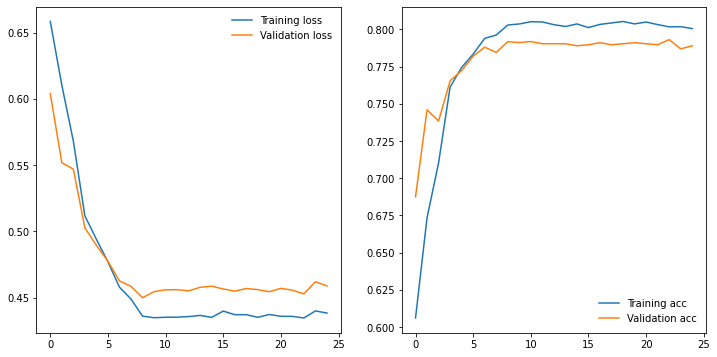

-----------------------------------------------------------
Test ACC: 0.7953.. 


In [ ]:
params1['EPOCHS'] = 25
params1['LEARNING_RATE'] = 0.001
#params1['CRITERION'] = nn.BCEWithLogitsLoss().to(device)
params1['CRITERION'] = nn.BCELoss().to(device)
params1['OPTIMIZER'] = 'ADAM'
params1['HIDDEN_DIM'] = 256
params1['EMBEDDING_DIM'] = 100
params1['OUTPUT_DIM'] = 1
params1['N_LAYERS'] = 1
params1['BIDIRECTIONAL'] = False
params1['DROPOUT'] = 0.3

INPUT_DIM = len(TEXT.vocab)
model = RNN(
      INPUT_DIM,
      params1['EMBEDDING_DIM'],
      params1['HIDDEN_DIM'],
      params1['OUTPUT_DIM'],
      params1['N_LAYERS'],
      params1['BIDIRECTIONAL'],
      params1['DROPOUT'],
      TEXT.vocab.stoi[TEXT.pad_token],
      TEXT.vocab.stoi[TEXT.unk_token],
      'RNN'
).to(device)

model, params1 = execute_model(model, params1, dataiter_train, dataiter_val, dataiter_test)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


RNN(
  (embedding): Embedding(15245, 100, padding_idx=1)
  (rnn): LSTM(100, 256, dropout=0.3)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Epoch: 1/15..  Train Loss: 0.6145..  Val Loss: 0.5714..  Train Acc: 0.6507..  Val Acc: 0.7204..  Time: 39.59s
Epoch: 2/15..  Train Loss: 0.4913..  Val Loss: 0.4281..  Train Acc: 0.7664..  Val Acc: 0.8224..  Time: 39.73s
Epoch: 3/15..  Train Loss: 0.4117..  Val Loss: 0.3886..  Train Acc: 0.8168..  Val Acc: 0.8434..  Time: 40.01s
Epoch: 4/15..  Train Loss: 0.3535..  Val Loss: 0.3666..  Train Acc: 0.8497..  Val Acc: 0.8466..  Time: 40.53s
Epoch: 5/15..  Train Loss: 0.2970..  Val Loss: 0.3300..  Train Acc: 0.8784..  Val Acc: 0.8651..  Time: 39.64s
Epoch: 6/15..  Train Loss: 0.2598..  Val Loss: 0.3260..  Train Acc: 0.8977..  Val Acc: 0.8756..  Time: 40.01s
Epoch: 7/15..  Train Loss: 0.2314..  Val Loss: 0.3226..  Train Acc: 0.9096..  Val Acc: 0.8901..  Time: 39.74s
Epoch: 8/15..  Train Loss: 0.196

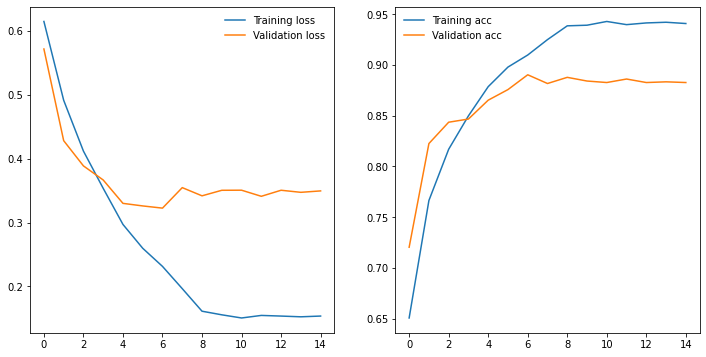

-----------------------------------------------------------
Test ACC: 0.8690.. 


In [ ]:
params1['EPOCHS'] = 15
params1['CRITERION'] = nn.BCELoss().to(device)
params1['OPTIMIZER'] = 'ADAM'
params1['N_LAYERS'] = 1
params1['BIDIRECTIONAL'] = False

INPUT_DIM = len(TEXT.vocab)
model = RNN(
      INPUT_DIM,
      params1['EMBEDDING_DIM'],
      params1['HIDDEN_DIM'],
      params1['OUTPUT_DIM'],
      params1['N_LAYERS'],
      params1['BIDIRECTIONAL'],
      params1['DROPOUT'],
      TEXT.vocab.stoi[TEXT.pad_token],
      TEXT.vocab.stoi[TEXT.unk_token],
      'LSTM'
).to(device)

model, params1 = execute_model(model, params1, dataiter_train, dataiter_val, dataiter_test)

RNN(
  (embedding): Embedding(15245, 100, padding_idx=1)
  (rnn): LSTM(100, 256, num_layers=2, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Epoch: 1/15..  Train Loss: 0.5853..  Val Loss: 0.5999..  Train Acc: 0.6800..  Val Acc: 0.7074..  Time: 219.94s
Epoch: 2/15..  Train Loss: 0.4660..  Val Loss: 0.4271..  Train Acc: 0.7795..  Val Acc: 0.8153..  Time: 219.13s
Epoch: 3/15..  Train Loss: 0.3621..  Val Loss: 0.3376..  Train Acc: 0.8405..  Val Acc: 0.8510..  Time: 219.75s
Epoch: 4/15..  Train Loss: 0.3148..  Val Loss: 0.3067..  Train Acc: 0.8672..  Val Acc: 0.8777..  Time: 219.67s
Epoch: 5/15..  Train Loss: 0.2733..  Val Loss: 0.2832..  Train Acc: 0.8876..  Val Acc: 0.8886..  Time: 221.32s
Epoch: 6/15..  Train Loss: 0.2384..  Val Loss: 0.2842..  Train Acc: 0.9045..  Val Acc: 0.8942..  Time: 220.65s
Epoch: 7/15..  Train Loss: 0.2135..  Val Loss: 0.2896..  Train Acc: 0.9153..  Val Acc: 0.8894..  Time:

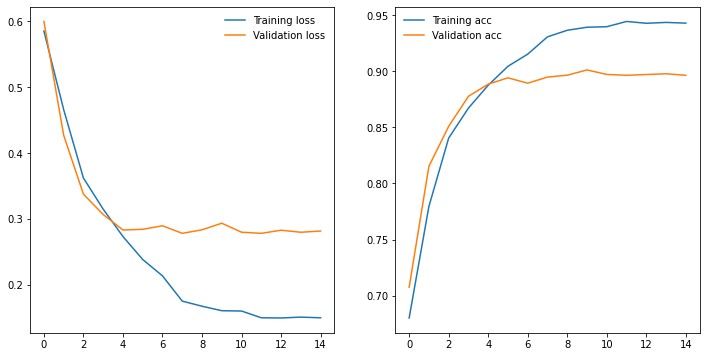

-----------------------------------------------------------
Test ACC: 0.8755.. 


In [ ]:
params1['EPOCHS'] = 15
params1['CRITERION'] = nn.BCELoss().to(device)
params1['OPTIMIZER'] = 'ADAM'
params1['N_LAYERS'] = 2
params1['BIDIRECTIONAL'] = True

INPUT_DIM = len(TEXT.vocab)
model = RNN(
      INPUT_DIM,
      params1['EMBEDDING_DIM'],
      params1['HIDDEN_DIM'],
      params1['OUTPUT_DIM'],
      params1['N_LAYERS'],
      params1['BIDIRECTIONAL'],
      params1['DROPOUT'],
      TEXT.vocab.stoi[TEXT.pad_token],
      TEXT.vocab.stoi[TEXT.unk_token]
).to(device)

model, params1 = execute_model(model, params1, dataiter_train, dataiter_val, dataiter_test)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


RNN(
  (embedding): Embedding(15245, 100, padding_idx=1)
  (rnn): GRU(100, 256, dropout=0.3)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Epoch: 1/15..  Train Loss: 0.5790..  Val Loss: 0.5029..  Train Acc: 0.6902..  Val Acc: 0.7723..  Time: 41.26s
Epoch: 2/15..  Train Loss: 0.4033..  Val Loss: 0.3638..  Train Acc: 0.8227..  Val Acc: 0.8509..  Time: 41.46s
Epoch: 3/15..  Train Loss: 0.3139..  Val Loss: 0.3011..  Train Acc: 0.8670..  Val Acc: 0.8751..  Time: 41.44s
Epoch: 4/15..  Train Loss: 0.2627..  Val Loss: 0.2913..  Train Acc: 0.8924..  Val Acc: 0.8846..  Time: 41.18s
Epoch: 5/15..  Train Loss: 0.2251..  Val Loss: 0.3047..  Train Acc: 0.9101..  Val Acc: 0.8966..  Time: 41.40s
Epoch: 6/15..  Train Loss: 0.1899..  Val Loss: 0.3218..  Train Acc: 0.9262..  Val Acc: 0.8748..  Time: 41.32s
Epoch: 7/15..  Train Loss: 0.1429..  Val Loss: 0.3154..  Train Acc: 0.9439..  Val Acc: 0.9003..  Time: 41.59s
Epoch: 8/15..  Train Loss: 0.1361

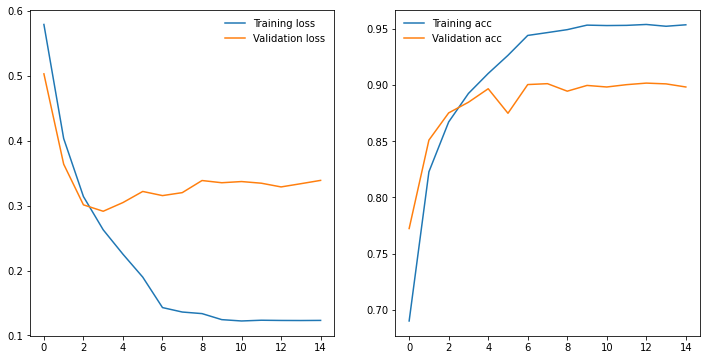

-----------------------------------------------------------
Test ACC: 0.8745.. 


In [ ]:
params1['EPOCHS'] = 15
params1['CRITERION'] = nn.BCELoss().to(device)
params1['OPTIMIZER'] = 'ADAM'
params1['N_LAYERS'] = 1
params1['BIDIRECTIONAL'] = False

INPUT_DIM = len(TEXT.vocab)
model = RNN(
      INPUT_DIM,
      params1['EMBEDDING_DIM'],
      params1['HIDDEN_DIM'],
      params1['OUTPUT_DIM'],
      params1['N_LAYERS'],
      params1['BIDIRECTIONAL'],
      params1['DROPOUT'],
      TEXT.vocab.stoi[TEXT.pad_token],
      TEXT.vocab.stoi[TEXT.unk_token],
      'GRU'
).to(device)

model, params1 = execute_model(model, params1, dataiter_train, dataiter_val, dataiter_test)

Avaliando os experimentos, o modelo mais simples, RNN, apresentou os resultados mais fracos. Os modelos LSTM e GRU ficaram parecidos. Utilizando mais camadas e com bidirecional True na LSTM, o tempo de treinamento aumentou  muito, mas não apresentou resultados significativamente melhores que o GRU. Será exportado o modelo GRU. É necessário exportar também os vocab que representam o texto e label para ser utilizado pelo modelo.

In [ ]:
#Salva modelo

torch.save(model, 'model_obj.pth')
torch.save(TEXT.vocab, 'text_vocab_obj.pth')
torch.save(LABEL.vocab, 'label_vocab_obj.pth')
torch.save(model.state_dict(), 'pesos_obj.pth')


# **Carregamento do modelo e predição**







A primeira célula abaixo somente é necessário executar se as demais células acima não foram executas. Ela fará os imports necessários e irá criar a classe do modelo RNN. O modelo exportado é pesado, por isto, exportei somente os seus pesos. Com isto, crio a estrutura do modelo e carrego os pesos (leve).

Necessário os arquivos **text_vocab_obj** e **label_vocab_obj**, pois, a classe RNN carrega eles para realizar o predict de um texto.

In [3]:
# Se executou as demais céculas, não precisa executar isto
import torch.nn as nn
import spacy
import numpy as np
import torch
import re

from bs4 import BeautifulSoup

class RNN(nn.Module):
    def __init__( self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx, unk_idx, tp='RNN'):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.nlp = spacy.load("en")
        if tp == 'RNN':
          self.rnn = nn.RNN(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout
        )
        elif tp == 'LSTM':
          self.rnn = nn.LSTM(
              embedding_dim,
              hidden_dim,
              num_layers=n_layers,
              bidirectional=bidirectional,
              dropout=dropout
          )
        elif tp == 'GRU':
          self.rnn = nn.GRU(
              embedding_dim,
              hidden_dim,
              num_layers=n_layers,
              bidirectional=bidirectional,
              dropout=dropout
          )
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.text_vocab = None
        self.label_vocab = None
        self.tp = tp
        
        self.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
        self.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)
        

    def clean_review_spacy_token(self, review):
        review = BeautifulSoup(review, "html.parser").get_text()
        review = review.lower()
        review = re.sub('[^a-z0-9]', ' ', review)
        review = [tok.text for tok in self.nlp.tokenizer(review)]
        review = [word for word in review if self.nlp.vocab[word].is_stop == False]
        review = [word.lemma_ for word in spacy.tokens.Doc(self.nlp.vocab, words=review)]
        while ' ' in review: review.remove(' ') #bug spacy
        return review

    def predict(self, review):
        if self.text_vocab is None:
          self.text_vocab = torch.load('text_vocab_obj.pth')
        if self.label_vocab is None:
          self.label_vocab = torch.load('label_vocab_obj.pth')

        self.eval()
        with torch.no_grad():
          tokenized = self.clean_review_spacy_token(review)
          indexed = [self.text_vocab.stoi[t] for t in tokenized]
          length = [len(indexed)]
          tensor = torch.LongTensor(indexed).to(device)
          tensor = tensor.unsqueeze(1)

          length_tensor = torch.LongTensor(length)
          prediction = self(tensor, length_tensor)
          prediction = int(torch.round(prediction.squeeze()))
          if self.label_vocab.stoi['neg'] == 1: # PARA GARANTIR QUE O RETORNO FIQUE DE ACORDO COM O ENUNCIADO (1 POSITIVO 0 NEGATIVO)
            prediction = 1 if prediction == 0 else 0
          return prediction

    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))

        # pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), enforce_sorted=False) # devido a um bug, tem que colocar como cpu
        
        if self.tp == 'LSTM':
          packed_output, (hidden, cell) = self.rnn(packed_embedded)
        else:
          packed_output, hidden = self.rnn(packed_embedded)
        
        # unpack sequence
        #output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        if self.rnn.num_layers == 2:
          hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        else:
          hidden = self.dropout(torch.cat((hidden[-1, :, :], hidden[0, :, :]), dim=1))
        return torch.sigmoid(self.fc(hidden))

In [4]:
# Para carregar o modelo, sem precisar da estrutura (porém, arquivo do modelo é pesado)
#model_load = torch.load('model_obj.pth')

# Crio o modelo (treinado e exportado) e carrego seus pesos. Necessário executar a célula contendo a classe RNN
model_load = RNN(
                  15245,
                  100,
                  256,
                  1,
                  1,
                  False,
                  0.3,
                  1,
                  0,
                  'GRU'
                  )

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
  model_load.load_state_dict(torch.load('pesos_obj.pth', map_location=torch.device('cpu')))
else:
  model_load.load_state_dict(torch.load('pesos_obj.pth'))

model_load = model_load.to(device)
model_load

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


RNN(
  (embedding): Embedding(15245, 100, padding_idx=1)
  (rnn): GRU(100, 256, dropout=0.3)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Testo o modelo carregado com um texto

In [5]:
text = "Worth the entertainment value of a rental, especially if you like action movies. This one features the usual car chases, fights with the great Van Damme kick style, shooting battles with the 40 shell load shotgun, and even terrorist style bombs. All of this is entertaining and competently handled but there is nothing that really blows you away if you've seen your share before.<br /><br />The plot is made interesting by the inclusion of a rabbit, which is clever but hardly profound. Many of the characters are heavily stereotyped -- the angry veterans, the terrified illegal aliens, the crooked cops, the indifferent feds, the bitchy tough lady station head, the crooked politician, the fat federale who looks like he was typecast as the Mexican in a Hollywood movie from the 1940s. All passably acted but again nothing special.<br /><br />I thought the main villains were pretty well done and fairly well acted. By the end of the movie you certainly knew who the good guys were and weren't. There was an emotional lift as the really bad ones got their just deserts. Very simplistic, but then you weren't expecting Hamlet, right? The only thing I found really annoying was the constant cuts to VDs daughter during the last fight scene.<br /><br />Not bad. Not good. Passable 4"
p = model_load.predict(text)
p

0

Testo o modelo carregado com o dataset de testes para ver o resultado.

In [ ]:
import pandas as pd
from torchtext import datasets

acc = 0

test_iter = datasets.IMDB(split='test')
df_test = pd.DataFrame(test_iter, columns=["sentiment", "review"])

for index, row in df_test.iterrows():
  p = model_load.predict(row.review)
  if p == (0 if row.sentiment == 'neg' else 1):
    acc += 1
print("Acurácia data frame teste:", acc/len(df_test))  

Acurácia data frame teste: 0.87504
